In [1]:
%cd ..

/home/shapkin/effective-inference


## Modules

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

from typing import Tuple, List, Dict, Optional, Union
from datasets import load_dataset
from datasets.arrow_dataset import Dataset
from datasets.dataset_dict import DatasetDict

from utils.prepare_dataset import load_datasets, cut_datasets
from utils.attention_patterns.bert_module_linear import LinearClassifierBertAttention, BertWrapperLin
# from utils.attention_patterns.gpt2_module_linear import 

## Pipeline

In [3]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel, GPT2LMHeadModel
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from statistics import mean

import torch
#from progressbar import progressbar
from tqdm.auto import tqdm
from torch import nn

from collections import defaultdict

import seaborn as sns
from sklearn.linear_model import SGDRegressor
import matplotlib.pyplot as plt
sns.set(style='darkgrid')
import numpy as np
import json
import h5py
import os
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from copy import deepcopy

### Pipeline configuration

In [4]:
LINEAR_CONFIG = {
    'd_model': 768,
    'device': 'cuda',
    'features': [
        'hidden_to', 'hidden_from', 'pos_to', 'pos_from'
    ],
    'batch_size': 1
}

In [5]:
class LinearAttention(nn.Module):
    def __init__(self, config):
        super(LinearAttention, self).__init__()
        self.dim_size = config['d_model']
        self.features = config['features']
        self.device = config['device']
        self.batch_size = config['batch_size']
        for k in self.features:
            if 'hidden' in k:
                learnable_parameters = f'torch.nn.Linear(in_features={self.dim_size}, out_features=1)'
                exec(f"self.{k} = {learnable_parameters}")
            else:
                #learnable_parameters = f'torch.nn.Linear(in_features=1, out_features=1)'
                learnable_parameters = f'nn.Parameter(torch.randn(1), requires_grad=True)'
                #self.register_parameter(f'{k}', nn.Parameter(torch.normal(mean=torch.tensor(0.0), std=torch.tensor(1.0))))
                print(f"self.{k} = {learnable_parameters}")
                exec(f"self.{k} = {learnable_parameters}")

    def forward(self, seq_len, **kwargs):
        result = torch.zeros((self.batch_size, seq_len, seq_len), device=self.device)
        for arg_name, arg_value in kwargs.items():
            # a = arg_value.clone()
            namespace = {'cur_result': None, 'self': self, 'arg_name': arg_name, 'arg_value': arg_value}
            if 'hidden' in arg_name:
                #print(f"result += self.{arg_name}(arg_value)")
                exec(f"cur_result = self.{arg_name}(arg_value)", namespace)
            else:
                #print(f"result += self.{arg_name} * arg_value")
                exec(f"cur_result = self.{arg_name} * arg_value", namespace)
            if 'from' in arg_name:
                result += namespace['cur_result'].T
            else:
                result += namespace['cur_result']
        return result

In [6]:
a = LinearAttention(LINEAR_CONFIG).to(LINEAR_CONFIG['device'])

self.pos_to = nn.Parameter(torch.randn(1), requires_grad=True)
self.pos_from = nn.Parameter(torch.randn(1), requires_grad=True)


In [7]:
a(1, **{
    'pos_to': torch.tensor([1], device=LINEAR_CONFIG['device']).view(1, -1),
    'pos_from': torch.tensor([1], device=LINEAR_CONFIG['device']).view(1, -1),
    'hidden_to': torch.randn(768, device=LINEAR_CONFIG['device']).view(1, -1),
    'hidden_from': torch.randn(768, device=LINEAR_CONFIG['device']).view(1, -1),
})

tensor([[[-0.0510]]], device='cuda:0', grad_fn=<AddBackward0>)

In [8]:
from transformers.models.bert.modeling_bert import BertSelfAttention, BertModel, \
    BaseModelOutputWithPastAndCrossAttentions

class LinearClassifierBertAttention(BertSelfAttention):
    """
    Idea: attention weights are predicted by Linear Classifier
    """
    def __init__(self, bert_config, linear_config):
        super(LinearClassifierBertAttention, self).__init__(bert_config)
        self.linear_config = linear_config
        self.linear_model = LinearAttention(linear_config)

    def forward(
            self,
            hidden_states: torch.Tensor,
            attention_mask: Optional[torch.FloatTensor] = None,
            head_mask: Optional[torch.FloatTensor] = None,
            encoder_hidden_states: Optional[torch.FloatTensor] = None,
            encoder_attention_mask: Optional[torch.FloatTensor] = None,
            past_key_value: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
            output_attentions: Optional[bool] = False,
            # special_tokens_idxs: Optional[List[int]] = [0]
    ) -> Tuple[torch.Tensor]:
        mixed_query_layer = self.query(hidden_states)

        # If this is instantiated as a cross-attention module, the keys
        # and values come from an encoder; the attention mask needs to be
        # such that the encoder's padding tokens are not attended to.
        is_cross_attention = encoder_hidden_states is not None

        if is_cross_attention and past_key_value is not None:
            # reuse k,v, cross_attentions
            key_layer = past_key_value[0]
            value_layer = past_key_value[1]
            attention_mask = encoder_attention_mask
            # special_tokens_idxs = (encoder_hidden_states[0] < 103).nonzero().squeeze()
        elif is_cross_attention:
            key_layer = self.transpose_for_scores(self.key(encoder_hidden_states))
            value_layer = self.transpose_for_scores(self.value(encoder_hidden_states))
            attention_mask = encoder_attention_mask
            # special_tokens_idxs = (encoder_hidden_states[0] < 103).nonzero().squeeze()
        elif past_key_value is not None:
            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))
            key_layer = torch.cat([past_key_value[0], key_layer], dim=2)
            value_layer = torch.cat([past_key_value[1], value_layer], dim=2)
        else:

            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))

        seq_len = hidden_states.shape[1]
        positions = torch.arange(seq_len).view(-1, 1)
        
        full_data_to_linear = {
            'hidden_from': hidden_states, 
            'hidden_to': hidden_states, 
            'pos_from': positions,
            'pos_to': positions,
            'relev_pos_from': seq_len - positions,
            'relev_pos_to': seq_len - positions,
            'inv_pos_from': (positions / seq_len),
            'inv_pos_to': (positions / seq_len),
            'inv_relev_pos_from': ((seq_len - positions) / seq_len),
            'inv_relev_pos_to': ((seq_len - positions) / seq_len),
            'seq_len': seq_len, 
            'inv_seq_len': (1 / seq_len),
        }

        data_to_linear = {k:full_data_to_linear[k].to(self.linear_config['device']) for k in self.linear_config['features']}
        predicted_attention= self.linear_model(seq_len, **data_to_linear)
        
        attention_probs = torch.exp(predicted_attention)  # torch.nn.functional.softmax(predicted_attention, dim=-1)
        context_layer = torch.matmul(attention_probs, value_layer.squeeze(1))

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(new_context_layer_shape)

        outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)

        if self.is_decoder:
            outputs = outputs + (past_key_value,)
        return outputs

class BertWrapperLin(nn.Module):
    def __init__(self, model, new_attention_class, layer_nums=None, window_size=2):
        super().__init__()

        self.bert_model = deepcopy(model)
        self.layer_nums = layer_nums

        # Create a list of modules to modify
        modules_to_modify = []
        for i in range(len(self.bert_model.encoder.layer)):
            if (layer_nums is not None and i in layer_nums) or (layer_nums is None):
                mean_attention = new_attention_class(self.bert_model.config, LINEAR_CONFIG) # self.bert_model.config, 
                #mean_attention.set_window_size(window_size)
                mean_attention.load_state_dict(self.bert_model.encoder.layer[i].attention.self.state_dict(), strict=False)

                self.bert_model.encoder.layer[i].attention.self = mean_attention

    def forward(self, *args, **kwargs):
        return self.bert_model(*args, **kwargs)

In [9]:
DEBUG_FLAG = True
CUT_SIZE = -1 if not DEBUG_FLAG else 200

model_name = 'bert-base-uncased' # 'gpt2'
tokenizer = AutoTokenizer.from_pretrained(model_name, max_length=1024)
initial_model = AutoModel.from_pretrained(model_name)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cpu':
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [10]:
# Wrapping model
model = BertWrapperLin(initial_model, LinearClassifierBertAttention, layer_nums=[9, 10])

self.pos_to = nn.Parameter(torch.randn(1), requires_grad=True)
self.pos_from = nn.Parameter(torch.randn(1), requires_grad=True)
self.pos_to = nn.Parameter(torch.randn(1), requires_grad=True)
self.pos_from = nn.Parameter(torch.randn(1), requires_grad=True)


In [11]:
try:
    dataset_name = list(glue_classification.keys())[0]
    glue_datasets = load_datasets('glue', list(glue_classification), CUT_SIZE)
except:
    glue_classification = {'mrpc': ['sentence1', 'sentence2']}
    dataset_name = 'mrpc'
    glue_datasets = load_datasets('glue', list(glue_classification), CUT_SIZE)

In [12]:
initial_model.to('cuda')

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [24]:
def get_dataset_for_regression(prob_of_take=0.01, layer=0, head_num=0):
    X_train, y_train = [], []
    X_test, y_test = [], []
    for ex_idx, ex in tqdm(enumerate(glue_datasets['mrpc']['train'])):
        if ex_idx > 100:
            break
    # for ex_idx, ex in enumerate(glue_datasets[dataset_name]['train'][:50]):
        if np.random.choice([0, 1], size=1, p=[0.8, 0.2])[0] > 0.2:
            encoded_inputs = tokenizer.encode(
                                        ex['sentence1'],
                                        ex['sentence2'],
                                        truncation=True,
                                        return_tensors='pt'
                                    )
            # special_symbols = (encoded_inputs[0] < 103).nonzero().squeeze()
            # for head_num in range(12):
            with h5py.File(f'notebooks/{dataset_name}/layer_{layer}/head_{head_num}/{ex_idx}.hdf5', 'r') as f:
    
                current_hidden_states = f['current_hidden_states'][()]
                next_hidden_states = f['next_hidden_states'][()]
                attentions = f['attentions'][()]
        
                len_of_seq = attentions.shape[0]
                for from_ in range(len_of_seq):
                    for to_ in range(len_of_seq):
                        if np.random.choice([0, 1], size=1, p=[1-prob_of_take, prob_of_take])[0] > 0.2:
                                        #feature_vector = []
                                        # (pos form, pos to, is_from_special_token, is_to_special_token,
                                        # len_of_seq, rel_position_from, rel_position_to, rev_pos_from, rev_pos_to, to_emb)
        
        
                            feature_vector = list(current_hidden_states[to_])
                            feature_vector.append(from_) # from_ pos
                            feature_vector.append(to_) # to_ pos
        
                            feature_vector.append(len_of_seq - from_) # from_ pos
                            feature_vector.append(len_of_seq - to_) # to_ pos
        
                            feature_vector.append(from_ / len_of_seq) # from_ pos
                            feature_vector.append(to_ / len_of_seq) # to_ pos
        
                            feature_vector.append((len_of_seq - from_) / len_of_seq) # from_ pos
                            feature_vector.append((len_of_seq - to_) / len_of_seq) # to_ pos
        
                            feature_vector.append(len_of_seq)
                            feature_vector.append(1/len_of_seq)
        
                            feature_vector.append(layer)
        
                                        #X_train.append(feature_vector)
                                        # y_train.append(np.log(max(attentions[from_, to_], 1e-10)))
        
                            X_train.append(feature_vector)
                            y_train.append(np.log(attentions[from_, to_]))
                        
    l = round(len(X_train)*0.95)
    X_test = X_train[l:]
    y_test = y_train[l:]
    X_train = X_train[:l]
    y_train = y_train[:l]
    
    return X_train, y_train, X_test, y_test

In [25]:
from sklearn.metrics import r2_score, mean_squared_error
import psutil

final_models = {}
final_coefs= {}
r2_list = {i: None for i in range(12)}

for layer in [11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]:
    r2_scores = 0
    print(f'Layer {layer}')
    #model = pipe_linear
    for i in range(12):
        X_train, y_train, X_test, y_test = get_dataset_for_regression(prob_of_take=0.3, layer=layer, head_num = i)
        print(psutil.cpu_percent(interval=1))
        print(f'Train: {len(X_train)}, Test: {len(X_test)}')
        model = learn_linear(model, id_scaler, id_scaler, X_train, y_train, X_test, y_test)
        preds_scaled = model.predict(X_test)
        preds = id_scaler(preds_scaled)
        r2_score_test = r2_score(y_test, preds)
        print('Test R2:', round(r2_score_test, 3))
    final_coefs[layer] = model.coef_()
    final_models[layer] = model
    r2_list[layer] = r2_score_test
    
    print()

Layer 11


101it [00:02, 34.97it/s]


2.7
Train: 13877, Test: 730


NameError: name 'learn_linear' is not defined

In [209]:
for layer in [11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]:
    r2_scores = 0
    model = final_models[layer]
    print(f'\nLayer {layer}\nTest R2: ')
    for head in range(12):
        X_train, y_train, X_test, y_test = get_dataset_for_regression(prob_of_take=0.3, layer=layer, head_num=head)
        preds_scaled = model.predict(X_test)
        preds = id_scaler(preds_scaled)
        r2_score_test = r2_score(y_test, preds)
        print(round(r2_score_test, 3), end=', ')
        r2_scores+=r2_score_test
    print('Test R2:', round(r2_scores/12, 3))
    r2_list[layer] = r2_scores/12

Layer 11
Test R2: 
-1.0338381813009373e+24, -2.1101127252327927e+24, -2.0353485597593304e+24, -1.7591164549034864e+24, -1.2388599466091317e+24, -1.2340844244053877e+24, -1.9185620298777632e+24, -5.946332183638694e+23, -1.264311068759002e+24, -2.7897430988708833e+24, -6.850136038467682e+23, -7.864703418000219e+23, Test R2: -1.4541744711441144e+24, Layer 10
Test R2: 
-1.930780146482044e+24, -6.728117166708672e+23, -2.3404864692550047e+24, -2.857305334276575e+24, -7.844373885954184e+23, -1.1268574522097496e+24, -1.7219426042377604e+24, -1.3391284802697502e+24, -2.628425764195192e+24, -8.055951352843256e+23, -4.1712393142078396e+23, -1.9392115089570737e+24, Test R2: -1.547008827654545e+24, Layer 9
Test R2: 
-8.199368476739781e+22, -2.3460751201718052e+23, -3.309640574320522e+23, -2.5884143354347348e+23, -2.7125862176735987e+23, -4.65437818949259e+23, -2.131544547908298e+23, -2.4239245141191015e+23, -3.1090214231561537e+23, -2.04881328193862e+23, -2.4336594759826523e+23, -5.4531156398755355

Inflection points: [2, 5, 7, 9]


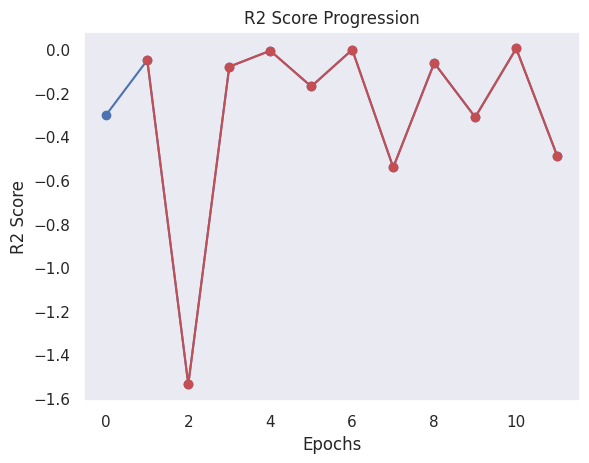

In [112]:
ans = r2_list

        
second_derivatives = []
first_derivatives = []
data = list(ans.values())
for i in range(1, len(data)-1):
    first_derivatives.append(data[i-1] - data[i])
    second_derivative = data[i+1] - 2 * data[i] + data[i-1]
    second_derivatives.append(second_derivative)
inflection_points = [i+1 for i, value in enumerate(second_derivatives) if value > 0 and first_derivatives[i]>0]
inflection_points = [list(ans.keys())[inflection_points[i]] for i in range(len(inflection_points))]

print("Inflection points:", inflection_points)

linear_layers = {}
linear_layers_r2 = {}
n = 12
for k, v in ans.items():
    if v>np.array(list(ans.values())).mean():
        n = k
    if  k >= n or k>inflection_points[0]:# and k not in inflection_points:
        linear_layers[k] = final_coefs[k]
        linear_layers_r2[k] = v

# Create x-axis values (e.g., epochs, iterations, etc.)
x_values = list(ans.keys())
y_values = list(ans.values())
x_values1 = list(linear_layers_r2.keys())
y_values1 = list(linear_layers_r2.values())
# Plot the line graphic
plt.plot(x_values, y_values, marker='o', linestyle='-', color='b')
plt.plot(x_values1, y_values1, marker='o', linestyle='-', color='r')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('R2 Score')
plt.title('R2 Score Progression')
plt.grid()
plt.show()
# linear_layers

### Evaluate Results

In [21]:
from sklearn.impute import SimpleImputer

tqdm_pbar = lambda x, y: tqdm(x, leave=True, position=0, total=len(x), desc=f'{y}')
def get_cls_embeddings_for_dataset(dataset_name, dataset, 
                                   feature_names, model, tokenizer, 
                                   pbar_func=tqdm_pbar, device=device, CUT_SIZE=CUT_SIZE):
    collected_embeddings = defaultdict(list)

    for split, data in dataset.items():
        
        pbar = pbar_func(data, f"{split} {dataset_name}") if pbar_func is not None else data
        for example in pbar:
            # Encode the input sentences
            if len(feature_names) == 2:
                encoded_inputs = tokenizer.encode(
                    example[feature_names[0]], 
                    example[feature_names[1]], 
                    truncation=True, 
                    return_tensors='pt'
                )
            else:
                encoded_inputs = tokenizer.encode(*list(map(lambda x: example[x] , feature_names)), 
                                              truncation=True, 
                                              return_tensors='pt')
            
            special_token_positions = (encoded_inputs[0] < 103).nonzero().squeeze()
            encoded_inputs = encoded_inputs.to(device)

            # print(f"Encoded inputs: {encoded_inputs}")
            # print(f"Special token positions: {special_token_positions}")
            
            # Forward pass through the model
            with torch.no_grad():
                outputs = model(encoded_inputs)
            # print(f'Outputs: {outputs}')

            # Get the embedding of the [CLS] token
            cls_embedding = outputs.last_hidden_state[:, 0, :]

            # Append the [CLS] embedding to the list
            collected_embeddings[split].append(cls_embedding)
         
    return collected_embeddings

def train_linear(X_train, y_train):
    classifier = LogisticRegression(solver='lbfgs', max_iter=3000)
    classifier.fit(X_train, y_train)
    return classifier

def evaluate_classifier(classifier, X, y=None):
    predictions = classifier.predict(X)
    return predictions

def get_metrics_report(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred,  average='weighted')
    print('Weighted F1', f1)
    print('Accuracy', accuracy)
    print('-------------------------------')

glue_classification = {'mrpc': ['sentence1', 'sentence2']} # , 'sst2':  ['sentence']}
superglue_classification = {'wic': ['sentence1', 'sentence2']}
all_classification = {'glue': glue_classification, 'superglue': superglue_classification}


glue_datasets = load_datasets('glue', list(glue_classification), 200)
superglue_datasets = load_datasets('super_glue', list(superglue_classification), 200)

all_datasets = {'glue': glue_datasets, 'superglue': superglue_datasets}

def check_results(custom_model, initial_model):

    for dn, datasets in all_datasets.items():
        for dataset_name, dataset in datasets.items():
            print(f"{dn.upper()} / {dataset_name}\n")

            print('Original')
            dataset_embeddings_orig = get_cls_embeddings_for_dataset(
                dataset_name,
                dataset, 
                all_classification[dn][dataset_name], 
                initial_model, 
                tokenizer)
            
            train_dataset_embeddings = torch.cat(dataset_embeddings_orig['train'], dim=0)
            valid_dataset_embeddings = torch.cat(dataset_embeddings_orig['validation'], dim=0)
            test_dataset_embeddings = torch.cat(dataset_embeddings_orig['test'], dim=0)
            
            classif = train_linear(train_dataset_embeddings.cpu(), [el['label'] for el in dataset['train']])
            valid_preds = evaluate_classifier(classif, valid_dataset_embeddings.cpu())
            print('Validation evaluation:\n')
            get_metrics_report([el['label'] for el in dataset['validation']], valid_preds)
            # print(train_dataset_embeddings.shape)

            
            print('\nLinear:')
            
            dataset_embeddings_custom = get_cls_embeddings_for_dataset(
                dataset_name,
                dataset, 
                all_classification[dn][dataset_name], 
                custom_model, 
                tokenizer
            )
            return dataset_embeddings_custom
            
            train_dataset_embeddings = torch.cat(dataset_embeddings_custom['train'], dim=0)
            valid_dataset_embeddings = torch.cat(dataset_embeddings_custom['validation'], dim=0)
            test_dataset_embeddings = torch.cat(dataset_embeddings_custom['test'], dim=0)


            classif = train_linear(train_dataset_embeddings.cpu(), [el['label'] for el in dataset['train']])
            valid_preds = evaluate_classifier(classif, valid_dataset_embeddings.cpu())
            print('Validation evaluation:\n')
            get_metrics_report([el['label'] for el in dataset['validation']], valid_preds)
            

In [19]:
device

device(type='cuda')

In [22]:
initial_model = initial_model.to(device)

custom_model = BertWrapperLin(initial_model, LinearClassifierBertAttention, layer_nums=[9, 10]).to('cuda')
# else: 
#     custom_model = GPT2WrapperLin(initial_model, LinearClassifierGPT2Attention, linear_layers,
                        # list(linear_layers.keys())).to(device)

a = check_results(custom_model, initial_model)

self.pos_to = nn.Parameter(torch.randn(1), requires_grad=True)
self.pos_from = nn.Parameter(torch.randn(1), requires_grad=True)
self.pos_to = nn.Parameter(torch.randn(1), requires_grad=True)
self.pos_from = nn.Parameter(torch.randn(1), requires_grad=True)
GLUE / mrpc

Original


test mrpc: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 91.73it/s]


Validation evaluation:

Weighted F1 0.6956793959319341
Accuracy 0.735
-------------------------------

Linear:


test mrpc: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 82.48it/s]


In [23]:
a

defaultdict(list,
            {'train': [tensor([[-2.6065e-01,  2.5596e-01,  9.7539e-01, -8.1687e-01, -9.4391e-01,
                        6.5553e-02, -2.1612e-01,  3.3908e-02, -8.9900e-02,  2.6661e-01,
                        2.6580e-01, -9.4857e-01, -3.9031e-01,  5.4093e-01,  7.6668e-01,
                       -9.5404e-01, -1.1223e+00,  2.7689e-01, -2.6088e-01, -2.4834e-02,
                       -4.6242e-01, -1.0752e-01,  1.4716e-01, -2.0856e-01, -2.0191e-01,
                       -2.8819e-01, -4.3161e-02,  7.3657e-01,  2.3062e-01, -4.6734e-01,
                       -8.2239e-02,  1.2287e+00, -7.9929e-01,  3.3930e-02,  2.5217e-01,
                        2.3906e-03,  7.1934e-01, -2.2694e-01, -1.6030e+00, -3.7756e-01,
                       -4.8915e-01, -1.8574e-01,  3.8179e-01,  2.3630e-01, -1.8477e-02,
                       -2.8983e-01,  7.3723e-01,  3.9556e-01,  1.5931e-01, -2.6660e-01,
                        1.0911e-01, -2.7270e-01, -2.2486e-01, -6.5530e-01, -1.0578e+00,
     

In [ ]:
custom_model

In [17]:
X_train

NameError: name 'X_train' is not defined